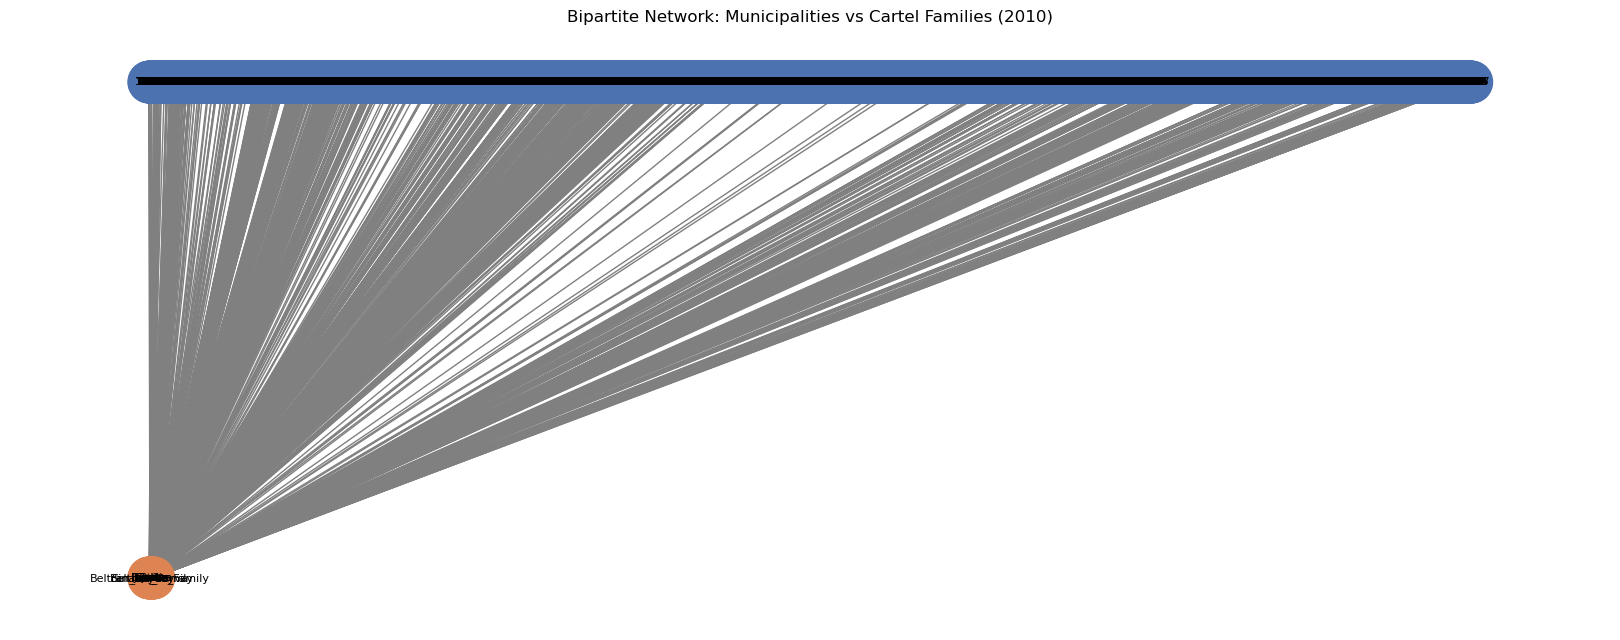

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# -----------------------------
# Load data
# -----------------------------
df = pd.read_csv("../data/CosciaRios2012_DataBase.csv")

# Filter only year 2010
df_2010 = df[df["Year"] == 2010]

# Cartel/family columns (adjust if needed)
family_cols = [
    "Beltran_Leyva",
    "Beltran_Leyva_Family",
    "Familia",
    "Golfo",
    "Juarez",
    "Sinaloa",
    "Sinaloa_Family",
    "Tijuana",
    "Zetas",
    "Otros"
]

# -----------------------------
# Build bipartite graph
# -----------------------------
B = nx.Graph()

# Add nodes
municipalities = df_2010["Code"].astype(str).unique()
families = family_cols

B.add_nodes_from(municipalities, bipartite=0)  # top layer
B.add_nodes_from(families, bipartite=1)        # bottom layer

# Add edges where cartel is present
for _, row in df_2010.iterrows():
    muni = str(row["Code"])
    for fam in family_cols:
        if row[fam] == 1:
            B.add_edge(muni, fam)

# -----------------------------
# Create bipartite layout
# -----------------------------
pos = {}

# x positions
pos.update({node: (i, 1) for i, node in enumerate(municipalities)})
pos.update({node: (i, 0) for i, node in enumerate(families)})

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(16, 6))

nx.draw(
    B,
    pos,
    with_labels=True,
    node_size=900,
    node_color=["#4C72B0" if n in municipalities else "#DD8452" for n in B.nodes()],
    edge_color="gray",
    font_size=8
)

plt.title("Bipartite Network: Municipalities vs Cartel Families (2010)")
plt.axis("off")
plt.show()


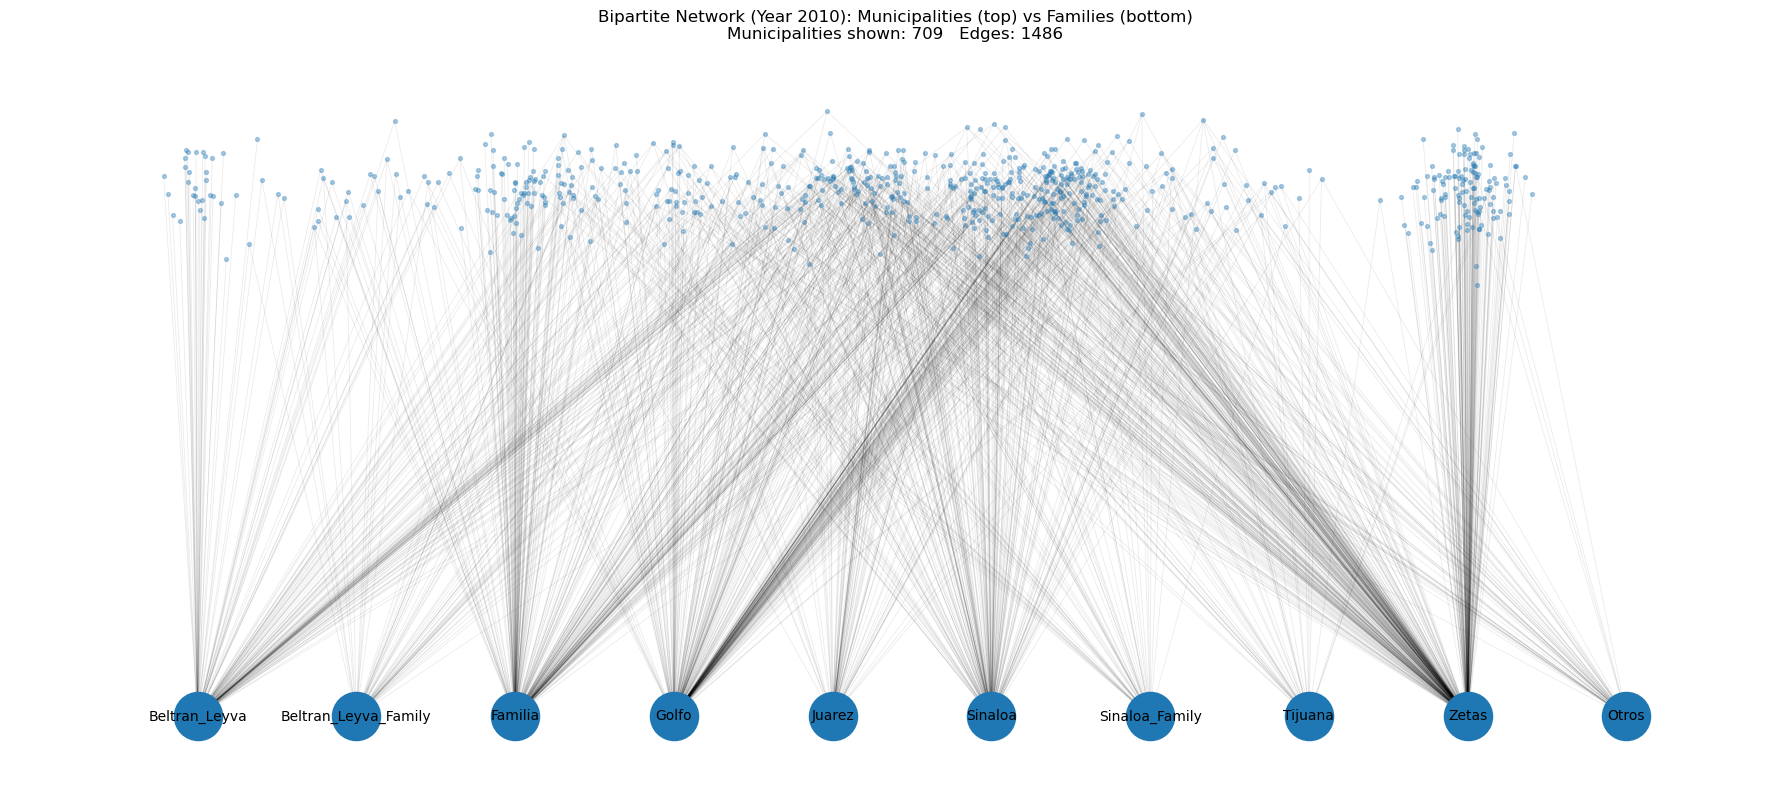

In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def plot_bipartite_2010(csv_path, year=2010, seed=42, max_munis=None):
    df = pd.read_csv(csv_path)
    df = df[df["Year"] == year].copy()

    family_cols = [
        "Beltran_Leyva",
        "Beltran_Leyva_Family",
        "Familia",
        "Golfo",
        "Juarez",
        "Sinaloa",
        "Sinaloa_Family",
        "Tijuana",
        "Zetas",
        "Otros"
    ]

    # Keep only municipalities that have at least one family present in this year
    df["active"] = df[family_cols].sum(axis=1)
    df = df[df["active"] > 0].drop(columns=["active"])

    # Optional: downsample municipalities for readability
    if max_munis is not None and len(df) > max_munis:
        df = df.sample(n=max_munis, random_state=seed)

    municipalities = df["Code"].astype(str).unique().tolist()
    families = family_cols

    # Build bipartite graph
    B = nx.Graph()
    B.add_nodes_from(municipalities, bipartite=0)
    B.add_nodes_from(families, bipartite=1)

    for _, row in df.iterrows():
        muni = str(row["Code"])
        for fam in families:
            if int(row[fam]) == 1:
                B.add_edge(muni, fam)

    rng = np.random.default_rng(seed)

    # --- Positions ---
    pos = {}

    # Fix family nodes evenly spaced on bottom
    fam_x = {fam: i for i, fam in enumerate(families)}
    for fam in families:
        pos[fam] = (fam_x[fam], 0.0)

    # Place municipalities at barycenter (mean x of connected families) + jitter
    # This prevents all families collapsing and makes the "fan-out" readable.
    for muni in municipalities:
        nbrs = list(B.neighbors(muni))
        if not nbrs:
            continue
        x_mean = np.mean([fam_x[f] for f in nbrs])
        x_jitter = rng.normal(0, 0.15)      # spread horizontally
        y_jitter = rng.normal(0, 0.05)      # tiny vertical noise
        pos[muni] = (x_mean + x_jitter, 1.0 + y_jitter)

    # --- Plot ---
    plt.figure(figsize=(18, 8))

    # Draw edges lightly (many edges = clutter)
    nx.draw_networkx_edges(B, pos, alpha=0.08, width=0.6)

    # Draw municipalities (no labels)
    nx.draw_networkx_nodes(
        B, pos,
        nodelist=municipalities,
        node_size=8,
        alpha=0.35
    )

    # Draw families (bigger, labeled)
    nx.draw_networkx_nodes(
        B, pos,
        nodelist=families,
        node_size=1200
    )
    nx.draw_networkx_labels(
        B, pos,
        labels={f: f for f in families},
        font_size=10
    )

    plt.title(f"Bipartite Network (Year {year}): Municipalities (top) vs Families (bottom)\n"
              f"Municipalities shown: {len(municipalities)}   Edges: {B.number_of_edges()}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_bipartite_2010("../data/CosciaRios2012_DataBase.csv", year=2010, max_munis=2457)


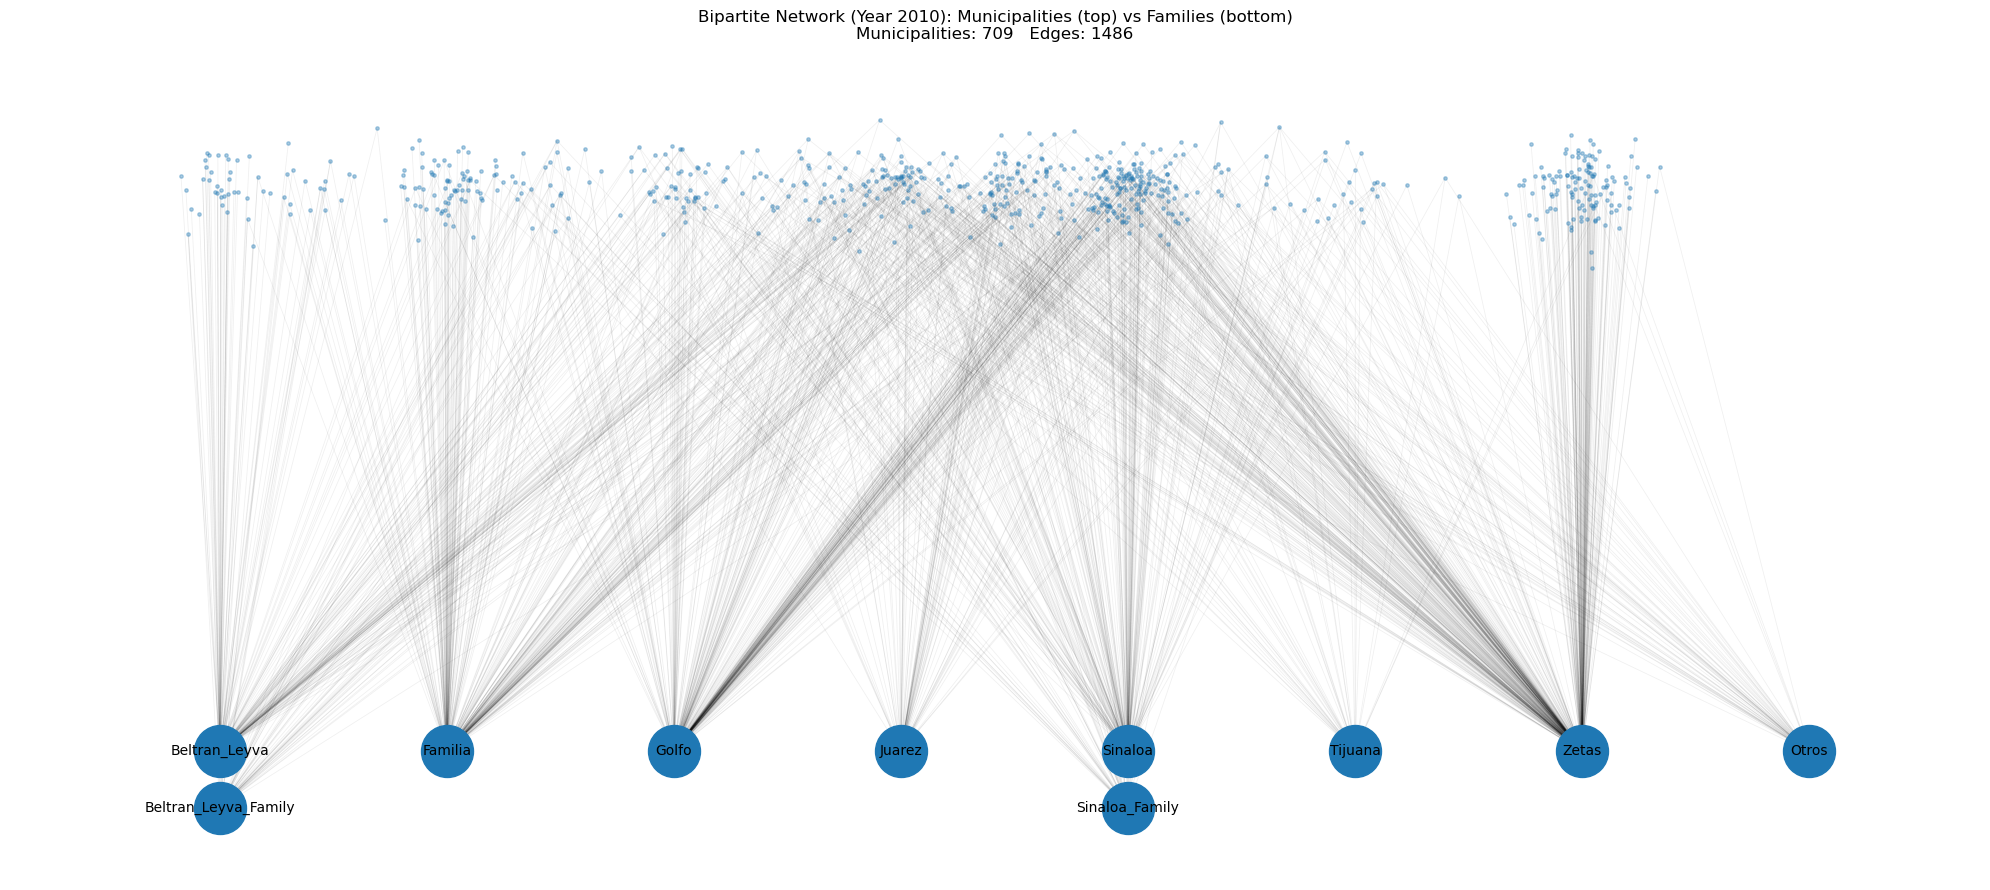

In [9]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def plot_bipartite_all_munis_2010(csv_path, year=2010, seed=42):
    df = pd.read_csv(csv_path)
    df = df[df["Year"] == year].copy()

    family_cols = [
        "Beltran_Leyva",
        "Beltran_Leyva_Family",
        "Familia",
        "Golfo",
        "Juarez",
        "Sinaloa",
        "Sinaloa_Family",
        "Tijuana",
        "Zetas",
        "Otros"
    ]

    # Keep municipalities with at least one active family in this year
    df = df[df[family_cols].sum(axis=1) > 0].copy()

    municipalities = df["Code"].astype(str).unique().tolist()
    families = family_cols

    # Build bipartite graph
    B = nx.Graph()
    B.add_nodes_from(municipalities, bipartite=0)
    B.add_nodes_from(families, bipartite=1)

    for _, row in df.iterrows():
        muni = str(row["Code"])
        for fam in families:
            if int(row[fam]) == 1:
                B.add_edge(muni, fam)

    rng = np.random.default_rng(seed)

    # --- X positions for families (bottom) ---
    # Make the "Family" variants share the same x as their base cartel.
    base_families = ["Beltran_Leyva", "Familia", "Golfo", "Juarez", "Sinaloa", "Tijuana", "Zetas", "Otros"]
    base_x = {fam: i for i, fam in enumerate(base_families)}

    fam_x = dict(base_x)
    fam_x["Beltran_Leyva_Family"] = base_x["Beltran_Leyva"]
    fam_x["Sinaloa_Family"] = base_x["Sinaloa"]

    # --- Positions ---
    pos = {}

    # Families on bottom (y=0), with tiny vertical offsets so the paired labels don't overlap
    label_y_offset = {
        "Beltran_Leyva": 0.00,
        "Beltran_Leyva_Family": -0.10,
        "Sinaloa": 0.00,
        "Sinaloa_Family": -0.10
    }
    for fam in families:
        pos[fam] = (fam_x[fam], 0.0 + label_y_offset.get(fam, 0.0))

    # Municipalities on top (y=1): mean x of their connected families + small jitter
    for muni in municipalities:
        nbrs = list(B.neighbors(muni))
        if not nbrs:
            continue
        x_mean = float(np.mean([fam_x[f] for f in nbrs]))
        pos[muni] = (x_mean + rng.normal(0, 0.12), 1.0 + rng.normal(0, 0.04))

    # --- Plot ---
    plt.figure(figsize=(20, 9))

    # Edges (very light because there are many)
    nx.draw_networkx_edges(B, pos, alpha=0.06, width=0.6)

    # Municipality nodes (small, no labels)
    nx.draw_networkx_nodes(
        B, pos,
        nodelist=municipalities,
        node_size=6,
        alpha=0.35
    )

    # Family nodes (bigger)
    nx.draw_networkx_nodes(
        B, pos,
        nodelist=families,
        node_size=1400
    )

    # Family labels only
    nx.draw_networkx_labels(
        B, pos,
        labels={f: f for f in families},
        font_size=10
    )

    plt.title(
        f"Bipartite Network (Year {year}): Municipalities (top) vs Families (bottom)\n"
        f"Municipalities: {len(municipalities)}   Edges: {B.number_of_edges()}"
    )
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Usage:
plot_bipartite_all_munis_2010("../data/CosciaRios2012_DataBase.csv", year=2010)
